# 自建GPT训练流程 - Part 2: 预训练 (Pretraining)

## 概述

本notebook演示如何对我们的小型GPT进行**预训练**，使用经典的**Next-Token Prediction**任务。

**设备建议：** CPU 可跑（GPU 可加速）。

### 预训练的核心思想

```
输入序列: [The, quick, brown, fox, jumps]
                ↓      ↓      ↓     ↓      ↓
预测目标: [quick, brown,  fox, jumps, over]

模型学习: P(next_token | previous_tokens)
```

### 预训练 vs SFT vs DPO

| 阶段 | 目标 | 数据 | 结果 |
|------|------|------|------|
| **预训练** | 学习语言规律 | 大量原始文本 | 会"说话"的模型 |
| **SFT** | 学习遵循指令 | (指令, 回答)对 | 会"听话"的模型 |
| **DPO** | 学习人类偏好 | (好回答, 差回答)对 | 会"选择"的模型 |

### 预训练关键机制（对齐主章 Ch6-Ch7）

- **数据 -> Token**：文本被分词器切成 token，再拼成固定 block_size。
- **标签右移**：input_ids[:-1] 预测 input_ids[1:]，即 Teacher Forcing。
- **因果掩码**：仅允许关注历史 token，避免信息泄露。
- **损失与评估**：交叉熵损失，常用指标为 Loss/Perplexity。
- **训练稳定性**：Warmup + Cosine、梯度裁剪，避免小模型发散。

> 本路线强调“从零可控”的完整链路，不追求 SOTA；主章 GPT-2 仅作工程演示。


## 环境设置

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import sys
import json
from collections import Counter

# 兼容从项目根目录或本目录运行
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..")) if os.path.basename(os.getcwd()) == "Custom_GPT_Training" else os.getcwd()
CUSTOM_GPT_DIR = os.path.join(PROJECT_ROOT, "Custom_GPT_Training")
sys.path.insert(0, CUSTOM_GPT_DIR)

from custom_gpt import (
    CustomGPT, 
    GPTConfig, 
    SimpleTokenizer,
    count_parameters
)

# 设备选择
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"使用设备: {device}")

# 可复现性
torch.manual_seed(42)
np.random.seed(42)

使用设备: cuda


## Part 1: 准备预训练数据

预训练需要大量的通用文本数据。这里读取 `data/custom_pretrain_corpus.txt` 作为示例语料，
内容保持客观、通用，并与后续的 SFT/DPO 任务尽量区分，以便更清晰地观察微调效果。

在实际应用中，可以替换为更大规模语料，例如：
- Wikipedia dump
- Common Crawl
- Books corpus
- GitHub code

In [2]:
# 示例预训练语料库（实际应用中会大得多）
# 读取 data/custom_pretrain_corpus.txt（通用中文语料，避免与后续SFT/DPO任务重合）

from pathlib import Path

def resolve_data_dir():
    candidates = [Path.cwd(), Path.cwd().parent]
    for base in candidates:
        data_dir = base / "data"
        if data_dir.exists():
            return str(data_dir)
    return os.path.join(os.getcwd(), "data")

DATA_DIR = resolve_data_dir()
PRETRAIN_PATH = os.path.join(DATA_DIR, "custom_pretrain_corpus.txt")

if os.path.exists(PRETRAIN_PATH):
    with open(PRETRAIN_PATH, "r", encoding="utf-8") as f:
        PRETRAIN_CORPUS = [line.strip() for line in f if line.strip()]
else:
    PRETRAIN_CORPUS = [
        "预训练语料文件不存在，使用内置示例文本。",
        "建议在 data/custom_pretrain_corpus.txt 中提供更丰富的中文语料。",
        "示例配置: {\"version\":\"1.0\",\"status\":\"ok\",\"retry\":3}。",
    ]

# 扩展语料（重复）以保证演示训练步数充足
target_size = 2000
if len(PRETRAIN_CORPUS) < target_size:
    repeat = target_size // len(PRETRAIN_CORPUS) + 1
    PRETRAIN_CORPUS = (PRETRAIN_CORPUS * repeat)[:target_size]

print(f"预训练语料: {len(PRETRAIN_CORPUS)} 条文本")
print(f"总字符数: {sum(len(t) for t in PRETRAIN_CORPUS)}")

预训练语料: 2000 条文本
总字符数: 31385


## Part 2: 构建预训练数据集

In [3]:
class PretrainDataset(Dataset):
    """
    预训练数据集
    
    将文本转换为固定长度的训练样本，用于next-token prediction。
    """
    
    def __init__(self, texts, tokenizer, max_length=128):
        """
        Args:
            texts: 文本列表
            tokenizer: 分词器
            max_length: 最大序列长度
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # 将所有文本编码并拼接成一个长序列
        all_ids = []
        for text in texts:
            ids = tokenizer.encode(text, add_bos=True, add_eos=True)
            all_ids.extend(ids)
        
        # 切分成训练样本
        self.samples = []
        for i in range(0, len(all_ids) - max_length, max_length // 2):  # 50% overlap
            sample = all_ids[i:i + max_length + 1]  # +1 for labels
            if len(sample) == max_length + 1:
                self.samples.append(sample)
        
        print(f"创建了 {len(self.samples)} 个训练样本")
        print(f"每个样本长度: {max_length}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # input_ids: [0, 1, 2, ..., n-1]
        # labels: [1, 2, 3, ..., n]
        input_ids = torch.tensor(sample[:-1], dtype=torch.long)
        labels = torch.tensor(sample[1:], dtype=torch.long)
        
        return {
            'input_ids': input_ids,
            'labels': labels
        }

In [4]:
# 构建或加载分词器
CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, "models", "custom_gpt")
tokenizer_path = os.path.join(CHECKPOINT_DIR, "tokenizer.pkl")

# 为ChatML保留必要字符，保证后续SFT/DPO可用
CHATML_SEED = [
    "<|system|>你是一个有帮助的AI助手。<|endoftext|>",
    "<|user|>示例问题<|endoftext|>",
    "<|assistant|>示例回答<|endoftext|>",
]
PRETRAIN_CORPUS = PRETRAIN_CORPUS + CHATML_SEED

REBUILD_TOKENIZER = True

if os.path.exists(tokenizer_path) and not REBUILD_TOKENIZER:
    print("加载已有分词器...")
    tokenizer = SimpleTokenizer.load(tokenizer_path)
else:
    print("构建新分词器...")
    tokenizer = SimpleTokenizer(vocab_size=5000, mode="char", min_freq=1)  # 中文用字符级
    tokenizer.build_vocab(PRETRAIN_CORPUS)
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    tokenizer.save(tokenizer_path)

print(f"词表大小: {len(tokenizer)}")

# 测试分词
test_text = "深度学习是人工智能的核心技术。"
encoded = tokenizer.encode(test_text)
decoded = tokenizer.decode(encoded)
print(f"\n测试分词:")
print(f"  原文: {test_text}")
print(f"  编码: {encoded[:20]}...")
print(f"  解码: {decoded}")

构建新分词器...
Vocabulary built: 381 tokens
词表大小: 381

测试分词:
  原文: 深度学习是人工智能的核心技术。
  编码: [1, 248, 40, 107, 109, 106, 307, 19, 3, 170, 101, 3, 3, 3, 3, 4, 2]...
  解码: 深度学习是人工能的。


In [5]:
# 创建数据集
MAX_LENGTH = 256
BATCH_SIZE = 16

dataset = PretrainDataset(PRETRAIN_CORPUS, tokenizer, max_length=MAX_LENGTH)

# 划分训练/验证集 (90/10)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

print(f"\n训练集: {len(train_dataset)} 样本")
print(f"验证集: {len(val_dataset)} 样本")

# 创建DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 查看一个batch
batch = next(iter(train_loader))
print(f"\n样本batch:")
print(f"  input_ids shape: {batch['input_ids'].shape}")
print(f"  labels shape: {batch['labels'].shape}")

创建了 276 个训练样本
每个样本长度: 256

训练集: 248 样本
验证集: 28 样本

样本batch:
  input_ids shape: torch.Size([16, 256])
  labels shape: torch.Size([16, 256])


## Part 3: 预训练Trainer

In [6]:
class PretrainTrainer:
    """
    预训练Trainer
    
    功能:
    - 标准的next-token prediction训练
    - 学习率warmup和cosine decay
    - 梯度裁剪
    - 验证集评估
    - checkpoint保存
    """
    
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        lr=1e-3,
        weight_decay=0.01,
        warmup_steps=100,
        max_grad_norm=1.0,
        device='cpu'
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.max_grad_norm = max_grad_norm
        self.warmup_steps = warmup_steps
        self.base_lr = lr
        
        # 优化器
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            betas=(0.9, 0.95)
        )
        
        # 训练历史
        self.train_losses = []
        self.val_losses = []
        self.lrs = []
        self.global_step = 0
    
    def get_lr(self, step, total_steps):
        """学习率调度: warmup + cosine decay"""
        if step < self.warmup_steps:
            # Linear warmup
            return self.base_lr * step / self.warmup_steps
        else:
            # Cosine decay
            progress = (step - self.warmup_steps) / (total_steps - self.warmup_steps)
            return self.base_lr * 0.5 * (1 + np.cos(np.pi * progress))
    
    def train_epoch(self, epoch, total_epochs):
        """训练一个epoch"""
        self.model.train()
        total_loss = 0
        total_steps = len(self.train_loader) * total_epochs
        
        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{total_epochs}")
        for batch in pbar:
            # 更新学习率
            lr = self.get_lr(self.global_step, total_steps)
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
            self.lrs.append(lr)
            
            # 准备数据
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['labels'].to(self.device)
            
            # 前向传播
            outputs = self.model(input_ids, labels=labels)
            loss = outputs['loss']
            
            # 反向传播
            self.optimizer.zero_grad()
            loss.backward()
            
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
            
            # 更新参数
            self.optimizer.step()
            
            # 记录
            total_loss += loss.item()
            self.train_losses.append(loss.item())
            self.global_step += 1
            
            # 更新进度条
            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'lr': f"{lr:.2e}"
            })
        
        return total_loss / len(self.train_loader)
    
    @torch.no_grad()
    def evaluate(self):
        """验证集评估"""
        self.model.eval()
        total_loss = 0
        
        for batch in self.val_loader:
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['labels'].to(self.device)
            
            outputs = self.model(input_ids, labels=labels)
            total_loss += outputs['loss'].item()
        
        avg_loss = total_loss / len(self.val_loader)
        self.val_losses.append(avg_loss)
        
        # 计算困惑度
        perplexity = np.exp(avg_loss)
        
        return avg_loss, perplexity
    
    def train(self, epochs, save_dir=None):
        """完整训练流程"""
        print(f"\n开始预训练")
        print(f"{'='*50}")
        print(f"  模型参数: {count_parameters(self.model)}")
        print(f"  训练样本: {len(self.train_loader.dataset)}")
        print(f"  验证样本: {len(self.val_loader.dataset)}")
        print(f"  Epochs: {epochs}")
        print(f"  设备: {self.device}")
        print(f"{'='*50}\n")
        
        best_val_loss = float('inf')
        
        for epoch in range(epochs):
            # 训练
            train_loss = self.train_epoch(epoch, epochs)
            
            # 验证
            val_loss, perplexity = self.evaluate()
            
            print(f"\nEpoch {epoch+1}/{epochs}:")
            print(f"  训练Loss: {train_loss:.4f}")
            print(f"  验证Loss: {val_loss:.4f}")
            print(f"  困惑度: {perplexity:.2f}")
            
            # 保存最佳模型
            if save_dir and val_loss < best_val_loss:
                best_val_loss = val_loss
                self.model.save_pretrained(os.path.join(save_dir, "pretrained_model"))
                print(f"  ✓ 保存最佳模型 (val_loss: {val_loss:.4f})")
        
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'learning_rates': self.lrs
        }

## Part 4: 执行预训练

In [7]:
# 模型配置
config = GPTConfig(
    vocab_size=len(tokenizer),
    max_seq_len=MAX_LENGTH,
    d_model=384,
    n_heads=6,
    n_layers=6,
    d_ff=1536,
    dropout=0.1
)

print("模型配置:")
print(f"  vocab_size: {config.vocab_size}")
print(f"  d_model: {config.d_model}")
print(f"  n_layers: {config.n_layers}")
print(f"  n_heads: {config.n_heads}")
print(f"  预估参数量: ~{config.num_params / 1e6:.2f}M")

模型配置:
  vocab_size: 381
  d_model: 384
  n_layers: 6
  n_heads: 6
  预估参数量: ~10.87M


In [8]:
# 创建模型
model = CustomGPT(config)
print(f"实际参数量: {count_parameters(model)}")

# 创建Trainer
trainer = PretrainTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=3e-4,
    weight_decay=0.01,
    warmup_steps=50,
    max_grad_norm=1.0,
    device=device
)

实际参数量: 14.31M


In [9]:
# 执行预训练
EPOCHS = 10  # 实际应用中需要更多epochs

history = trainer.train(
    epochs=EPOCHS,
    save_dir=CHECKPOINT_DIR
)


开始预训练
  模型参数: 14.31M
  训练样本: 248
  验证样本: 28
  Epochs: 10
  设备: cuda



Epoch 1/10:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 1/10:
  训练Loss: 5.5799
  验证Loss: 4.9570
  困惑度: 142.16
Model saved to c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\pretrained_model
  ✓ 保存最佳模型 (val_loss: 4.9570)


Epoch 2/10:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 2/10:
  训练Loss: 4.3958
  验证Loss: 3.3995
  困惑度: 29.95
Model saved to c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\pretrained_model
  ✓ 保存最佳模型 (val_loss: 3.3995)


Epoch 3/10:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 3/10:
  训练Loss: 2.7883
  验证Loss: 1.8164
  困惑度: 6.15
Model saved to c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\pretrained_model
  ✓ 保存最佳模型 (val_loss: 1.8164)


Epoch 4/10:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 4/10:
  训练Loss: 1.7773
  验证Loss: 1.1920
  困惑度: 3.29
Model saved to c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\pretrained_model
  ✓ 保存最佳模型 (val_loss: 1.1920)


Epoch 5/10:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 5/10:
  训练Loss: 1.2053
  验证Loss: 0.7971
  困惑度: 2.22
Model saved to c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\pretrained_model
  ✓ 保存最佳模型 (val_loss: 0.7971)


Epoch 6/10:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 6/10:
  训练Loss: 0.7747
  验证Loss: 0.5270
  困惑度: 1.69
Model saved to c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\pretrained_model
  ✓ 保存最佳模型 (val_loss: 0.5270)


Epoch 7/10:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 7/10:
  训练Loss: 0.5216
  验证Loss: 0.3525
  困惑度: 1.42
Model saved to c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\pretrained_model
  ✓ 保存最佳模型 (val_loss: 0.3525)


Epoch 8/10:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 8/10:
  训练Loss: 0.3629
  验证Loss: 0.2771
  困惑度: 1.32
Model saved to c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\pretrained_model
  ✓ 保存最佳模型 (val_loss: 0.2771)


Epoch 9/10:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 9/10:
  训练Loss: 0.2952
  验证Loss: 0.2552
  困惑度: 1.29
Model saved to c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\pretrained_model
  ✓ 保存最佳模型 (val_loss: 0.2552)


Epoch 10/10:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 10/10:
  训练Loss: 0.2713
  验证Loss: 0.2501
  困惑度: 1.28
Model saved to c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\pretrained_model
  ✓ 保存最佳模型 (val_loss: 0.2501)


C:\Users\lvbab\AppData\Local\Temp\ipykernel_68252\840705804.py:31: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lvbab\AppData\Local\Temp\ipykernel_68252\840705804.py:31: UserWarning: Glyph 28369 (\N{CJK UNIFIED IDEOGRAPH-6ED1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
e:\conda\envs\llmc\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\conda\envs\llmc\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28369 (\N{CJK UNIFIED IDEOGRAPH-6ED1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


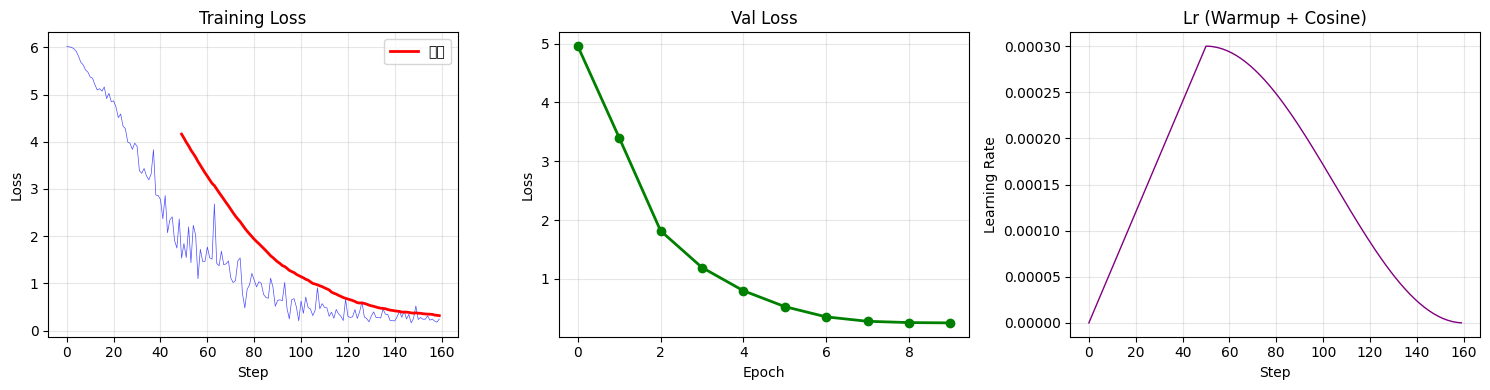

In [10]:
# 可视化训练过程
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 训练Loss
axes[0].plot(history['train_losses'], 'b-', alpha=0.7, linewidth=0.5)
# 平滑曲线
window = 50
if len(history['train_losses']) > window:
    smoothed = np.convolve(history['train_losses'], np.ones(window)/window, mode='valid')
    axes[0].plot(range(window-1, len(history['train_losses'])), smoothed, 'r-', linewidth=2, label='平滑')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 验证Loss
axes[1].plot(history['val_losses'], 'g-o', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Val Loss')
axes[1].grid(True, alpha=0.3)

# 学习率
axes[2].plot(history['learning_rates'], 'purple', linewidth=1)
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Lr (Warmup + Cosine)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 5: 测试预训练模型

In [11]:
# 加载最佳模型
pretrained_model = CustomGPT.from_pretrained(
    os.path.join(CHECKPOINT_DIR, "pretrained_model")
).to(device)

print(f"加载预训练模型: {count_parameters(pretrained_model)}")

Model loaded from c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\pretrained_model
加载预训练模型: 14.31M


In [12]:
def generate_text(model, tokenizer, prompt, max_new_tokens=50, temperature=0.8, top_k=50):
    """生成文本"""
    model.eval()
    
    # 编码prompt
    input_ids = torch.tensor([tokenizer.encode(prompt, add_bos=True, add_eos=False)]).to(device)
    
    # 生成
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_k=top_k,
            do_sample=True
        )
    
    # 解码
    generated = tokenizer.decode(output_ids[0].tolist())
    return generated

In [13]:
# 测试生成
test_prompts = [
    "深度学习",
    "机器学习是",
    "Transformer架构",
    "语言模型",
]

print("预训练模型生成测试:")
print("=" * 60)

for prompt in test_prompts:
    generated = generate_text(
        pretrained_model, 
        tokenizer, 
        prompt,
        max_new_tokens=30,
        temperature=0.7
    )
    print(f"\nPrompt: '{prompt}'")
    print(f"生成: {generated}")
    print("-" * 40)

预训练模型生成测试:

Prompt: '深度学习'
生成: 深度学习习习习长习习习习习习学据据学学数习习习法测果
----------------------------------------

Prompt: '机器学习是'
生成: 机器学习是神量量神步。r是是模阵是量量量录参随种。ot是S在常为为
----------------------------------------

Prompt: 'Transformer架构'
生成: Transformer构机序规可释。oe 用注力制理列其不子力制应预下个。oe 
----------------------------------------

Prompt: '语言模型'
生成: 语言模型练要注解性
----------------------------------------


In [14]:
# 不同温度对比
prompt = "机器学习"
temperatures = [0.3, 0.7, 1.0, 1.5]

print(f"Prompt: '{prompt}'")
print("\n不同温度的生成效果:")
print("=" * 60)

for temp in temperatures:
    generated = generate_text(
        pretrained_model, 
        tokenizer, 
        prompt,
        max_new_tokens=30,
        temperature=temp
    )
    print(f"\n温度={temp}: {generated}")

Prompt: '机器学习'

不同温度的生成效果:

温度=0.3: 机器学习习习习习习习习习习习习习习习的的长长长长长长长律律做测测测测

温度=0.7: 机器学习。型练小让型练要立度回策。型练要注解性

温度=1.0: 机器学习列文/   步。拟tzU一能合阵分tsot逻。e口制算号

温度=1.5: 机器学习号案


## Part 6: 计算困惑度 (Perplexity)

In [15]:
@torch.no_grad()
def compute_perplexity(model, dataloader, device):
    """计算模型在数据集上的困惑度"""
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, labels=labels)
        total_loss += outputs['loss'].item() * input_ids.numel()
        total_tokens += input_ids.numel()
    
    avg_loss = total_loss / total_tokens
    perplexity = np.exp(avg_loss)
    
    return perplexity, avg_loss

# 计算困惑度
ppl, loss = compute_perplexity(pretrained_model, val_loader, device)
print(f"预训练模型评估:")
print(f"  验证Loss: {loss:.4f}")
print(f"  困惑度 (Perplexity): {ppl:.2f}")
print(f"\n说明: 困惑度越低表示模型越好。对于词表大小{len(tokenizer)}的模型，")
print(f"      随机猜测的困惑度约为{len(tokenizer)}")

预训练模型评估:
  验证Loss: 0.2422
  困惑度 (Perplexity): 1.27

说明: 困惑度越低表示模型越好。对于词表大小381的模型，
      随机猜测的困惑度约为381


## 总结

### 本notebook完成的内容

1. **数据准备**
   - 构建预训练语料库
   - 创建PretrainDataset类（滑动窗口切分）
   - 划分训练/验证集

2. **预训练Trainer**
   - 标准的next-token prediction训练
   - 学习率warmup + cosine decay
   - 梯度裁剪
   - checkpoint保存

3. **模型评估**
   - 计算困惑度 (Perplexity)
   - 文本生成测试
   - 不同温度对比

### 预训练模型的能力

预训练后的模型学会了：
- 基本的语言模式（词语搭配、句子结构）
- 领域知识（AI/ML相关术语和概念）
- 文本续写能力

但还不会：
- 遵循指令（需要SFT）
- 生成高质量、人类偏好的回答（需要DPO）

### 下一步: SFT训练 (03_SFT_Training.ipynb)

在下一个notebook中，我们将对预训练模型进行指令微调（SFT），让它学会遵循用户指令。